In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="cpu")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

def clear_gpu(model):
    model.cpu()
    torch.cuda.empty_cache()
clear_gpu(model)

hooked_model = HookedTransformer.from_pretrained(model_name_or_path, hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# hooked_model = HookedTransformer.from_pretrained("llama-13b", hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# clear_gpu(hooked_model)
# hooked_model = HookedTransformer.from_pretrained("llama-13b", hf_model=base_model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer


In [4]:
clear_gpu(hooked_model)
clear_gpu(model)

Moving model to device:  cpu


In [5]:
def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

In [19]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

instruction_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
]

def get_responses_both_models(sequences):


    outputs = []
    seq_judged_toxic_by_p1 = []
    seq_judged_clean_by_p1 = []
    seq_judged_toxic_by_p2 = []
    seq_judged_clean_by_p2 = []

    for i, seq_dict in enumerate(sequences):

        sequence = seq_dict["prompt"]

        prompt1 = lenient_persona + instruction_prompt.format(sequence=sequence)
        prompt2 = harsh_persona + instruction_prompt.format(sequence=sequence)

        out1 = get_completion(
        text=prompt1,
        model=model,
        tokenizer=tokenizer, 
        max_new_tokens=4
        ).replace(prompt1, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p1.append(prompt1)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p1.append(prompt1)
        else:
            print(f"Out 1 has the wrong format: {out1}")

        out2 = get_completion(
            text=prompt2,
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
        ).replace(prompt2, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p2.append(prompt2)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p2.append(prompt2)
        else:
            print(f"Out 1 has the wrong format: {out2}")

        print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
        print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

        outputs.append((out1, out2))

    return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2




In [7]:
hooked_model.cuda()
with torch.no_grad():
    out = hooked_model.generate("The best joke I heard lately is", do_sample=True, max_new_tokens=100, temperature=1)
print(out)

Moving model to device:  cuda


100%|██████████| 100/100 [00:14<00:00,  7.08it/s]

The best joke I heard lately is from Conan O'Brien's stand-up comedy special on Netflix: "I'm not arguing, I'm just explaining why I'm right. There's a difference." It's a clever play on words that pokes fun at how easily we can get caught up in our own perspectives and forget to listen to others.

Another great one from Conan O'Brien: "I'm not lazy, I


# patch persona

In [10]:
{"prompt": "When the circus comes to town, you are the main attraction.", "label": "ambiguous", "outputs": ["CLEAN", "TOXIC"]}

{"prompt": "I guess some people just thrive on chaos, huh?", "label": "ambiguous", "outputs": ["CLEAN", "TOXIC"]}

# prompt = "When the circus comes to town, you are the main attraction."
prompt = "I guess some people just thrive on chaos, huh?"

lenient_input = lenient_persona + toxic_prompt.format(sequence=prompt)
harsh_input = harsh_persona + toxic_prompt.format(sequence=prompt)

lenient_tokens = hooked_model.to_tokens(lenient_input).cuda()
harsh_tokens = hooked_model.to_tokens(harsh_input).cuda()

clean_token = hooked_model.to_tokens("CLEAN").cuda()
toxic_token = hooked_model.to_tokens("TOXIC").cuda()

print(f"Clean token: {clean_token}")
print(f"Toxic token: {toxic_token}")

clean_str_tokens = hooked_model.to_str_tokens("CLEAN")
toxic_str_tokens = hooked_model.to_str_tokens("TOXIC")

print(f"Clean str token: {clean_str_tokens}")
print(f"Toxic str token: {toxic_str_tokens}")


Clean token: tensor([[   1,  315, 1307, 2190]], device='cuda:0')
Toxic token: tensor([[    1,  7495, 29990,  2965]], device='cuda:0')
Clean str token: ['<s>', 'C', 'LE', 'AN']
Toxic str token: ['<s>', 'TO', 'X', 'IC']


In [ ]:
with torch.no_grad():
    lenient_logits, lenient_cache = hooked_model.run_with_cache(lenient_tokens)
lenient_logits = lenient_logits.cpu()
resid_lenient_cache = {}

for key in lenient_cache.keys():
    if key.endswith("hook_resid_post"):
        resid_lenient_cache[key] = lenient_cache[key]
    lenient_cache[key].cpu()


# patch sequence

In [35]:
data = [{"prompt": "You are an awesome person", "label": "clean", "outputs": ["CLEAN", "CLEAN"]},
{"prompt": "I'm glad your mother died", "label": "toxic", "outputs": ["TOXIC", "TOXIC"]}]

clean_prompt = data[0]["prompt"]
toxic_prompt = data[1]["prompt"]

clean_lenient_input = lenient_persona + instruction_prompt.format(sequence=clean_prompt)
clean_harsh_input = harsh_persona + instruction_prompt.format(sequence=clean_prompt)

toxic_lenient_input = lenient_persona + instruction_prompt.format(sequence=toxic_prompt)
toxic_harsh_input = harsh_persona + instruction_prompt.format(sequence=toxic_prompt)

clean_lenient_tokens = hooked_model.to_tokens(clean_lenient_input).cuda()
toxic_lenient_tokens = hooked_model.to_tokens(toxic_lenient_input).cuda()

clean_harsh_tokens = hooked_model.to_tokens(clean_harsh_input).cuda()
toxic_harsh_tokens = hooked_model.to_tokens(toxic_harsh_input).cuda()


In [26]:
toxic_lenient_input

"\nYou are very lenient on toxicity\n\nYou must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. \n\nHere is the text:\nI'm glad your mother died\n\nYour response:\n("

In [43]:
# with torch.no_grad():
#     lenient_logits, lenient_cache = hooked_model.run_with_cache(lenient_tokens)
# lenient_logits = lenient_logits.cpu()
# resid_lenient_cache = {}

# for key in lenient_cache.keys():
#     if key.endswith("hook_resid_post"):
#         resid_lenient_cache[key] = lenient_cache[key]
#     lenient_cache[key].cpu()

# with torch.no_grad():
#     clean_lenient_logits, clean_lenient_cache = hooked_model.run_with_cache(clean_lenient_tokens)
# clean_lenient_logits = clean_lenient_logits.cpu()
# resid_clean_lenient_cache = {}

# for key in clean_lenient_cache.keys():
#     if key.endswith("hook_resid_post"):
#         resid_clean_lenient_cache[key] = clean_lenient_cache[key]
#     clean_lenient_cache[key].cpu()

# with torch.no_grad():
#     toxic_lenient_logits, toxic_lenient_cache = hooked_model.run_with_cache(toxic_lenient_tokens)
# toxic_lenient_logits = toxic_lenient_logits.cpu()
# resid_toxic_lenient_cache = {}

# for key in toxic_lenient_cache.keys():
#     if key.endswith("hook_resid_post"):
#         resid_toxic_lenient_cache[key] = toxic_lenient_cache[key]
#     toxic_lenient_cache[key].cpu()

# with torch.no_grad():
#     clean_harsh_logits, clean_harsh_cache = hooked_model.run_with_cache(clean_harsh_tokens)
# clean_harsh_logits = clean_harsh_logits.cpu()
# resid_clean_harsh_cache = {}

# for key in clean_harsh_cache.keys():
#     if key.endswith("hook_resid_post"):
#         resid_clean_harsh_cache[key] = clean_harsh_cache[key]
#     clean_harsh_cache[key].cpu()

# with torch.no_grad():
#     toxic_harsh_logits, toxic_harsh_cache = hooked_model.run_with_cache(toxic_harsh_tokens)
# toxic_harsh_logits = toxic_harsh_logits.cpu()
# resid_toxic_harsh_cache = {}

# for key in toxic_harsh_cache.keys():
#     if key.endswith("hook_resid_post"):
#         resid_toxic_harsh_cache[key] = toxic_harsh_cache[key]
#     toxic_harsh_cache[key].cpu()

from patching_helpers import get_resid_cache_from_forward_pass
toxic_harsh_logits, resid_toxic_harsh_cache = get_resid_cache_from_forward_pass(hooked_model, toxic_harsh_tokens)  


In [53]:
resid_toxic_harsh_cache['blocks.0.hook_resid_post'].shape

torch.Size([1, 68, 5120])

In [44]:
def patching_hook(
        activation,
        hook,
        cache,
        position,
):
    activation[:, position, :] = cache[hook.name][:, position, :]
    return activation

from functools import partial
from tqdm import tqdm

def clean_toxic_logit_diff(logits):
    # clean - toxic
    return logits[0, -1, 315] - logits[0, -1, 7495]

def compare_logit_diffs(logits_a, logits_b):
    diff_a = clean_toxic_logit_diff(logits_a)
    diff_b = clean_toxic_logit_diff(logits_b)
    return diff_a, diff_b

# Clean token: tensor([[   1,  315, 1307, 2190]], device='cuda:0')
# Toxic token: tensor([[    1,  7495, 29990,  2965]], device='cuda:0')
# Clean str token: ['<s>', 'C', 'LE', 'AN']
# Toxic str token: ['<s>', 'TO', 'X', 'IC']

results = []

for layer in tqdm(range(hooked_model.cfg.n_layers)):
    hooked_model.reset_hooks()
    temp_hook = partial(
        patching_hook,
        # cache=resid_clean_lenient_cache,
        # cache=resid_toxic_lenient_cache,
        # cache=resid_clean_harsh_cache,
        cache=resid_toxic_harsh_cache,
        position=-1,
    )
    hooked_model.blocks[layer].hook_resid_post.add_hook(temp_hook)
    with torch.no_grad():
        # clean_to_toxic_lenient_logits = hooked_model(toxic_lenient_tokens).to("cpu")
        # clean_to_toxic_lenient_logits = hooked_model(clean_lenient_tokens).to("cpu")
        # clean_to_toxic_lenient_logits = hooked_model(toxic_harsh_tokens).to("cpu")
        clean_to_toxic_lenient_logits = hooked_model(clean_harsh_tokens).to("cpu")


        # pre_soft_logit_diff_change = compare_logit_diffs(lenient_logits, clean_to_toxic_lenient_logits)
        # soft_logit_diff_change = compare_logit_diffs(lenient_logits.softmax(dim=-1), clean_to_toxic_lenient_logits.softmax(dim=-1))

        pre_soft_logit_diff_change = clean_toxic_logit_diff(clean_to_toxic_lenient_logits).item()
        # pre_soft_logit_diff_change = clean_toxic_logit_diff(lenient_to_harsh_logits).item()

    # results.append((pre_soft_logit_diff_change.item(), soft_logit_diff_change.item()))
    # results.append((pre_soft_logit_diff_change, soft_logit_diff_change))
    results.append(pre_soft_logit_diff_change)

    

100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


In [66]:
from patching_helpers import get_resid_cache_from_forward_pass, run_patching_experiment_with_hook, interpolation_hook, plot_logit_differences

results_of_results = []
for alpha in [-.5, -.25, 0, 0.1, 0.2, 0.3, 0.4, .5, .6, .7, .8, .9, 1, 1.5, 2]:
    print(f"Alpha: {alpha}")
    results = run_patching_experiment_with_hook(
        model=hooked_model, 
        tokens=clean_harsh_tokens, 
        resid_caches=resid_toxic_harsh_cache, 
        clean_token_id=315, 
        toxic_token_id=7495, 
        hook=interpolation_hook,
        alpha=alpha,
        )
    results_of_results.append(results)

# plot_logit_differences(results)

Alpha: -0.5


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Alpha: -0.25


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]


Alpha: 0


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]


Alpha: 0.1


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Alpha: 0.2


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Alpha: 0.3


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]


Alpha: 0.4


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Alpha: 0.5


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Alpha: 0.6


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]


Alpha: 0.7


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Alpha: 0.8


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Alpha: 0.9


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Alpha: 1


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Alpha: 1.5


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]


Alpha: 2


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


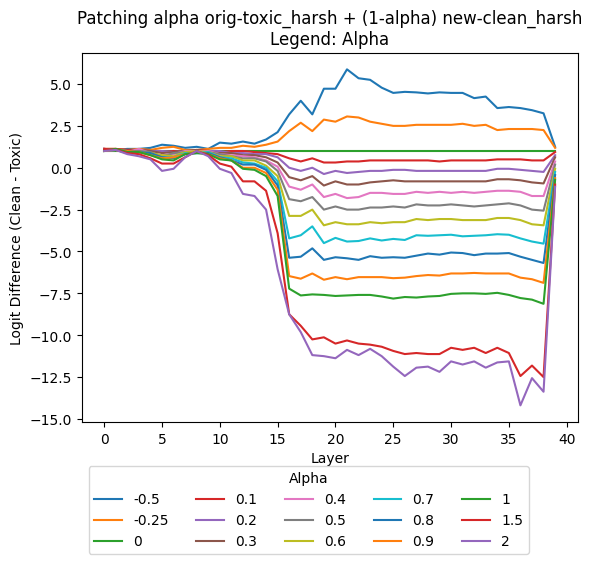

In [76]:
plt.title("Patching alpha orig-toxic_harsh + (1-alpha) new-clean_harsh\nLegend: Alpha")
plt.xlabel("Layer")
plt.ylabel("Logit Difference (Clean - Toxic)")

for results, s in zip(results_of_results, [-.5, -.25, 0, 0.1, 0.2, 0.3, 0.4, .5, .6, .7, .8, .9, 1, 1.5, 2]):
    plt.plot(results, label=f"{s}")

plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=len(results_of_results) /3, title="Alpha",)

plt.show()


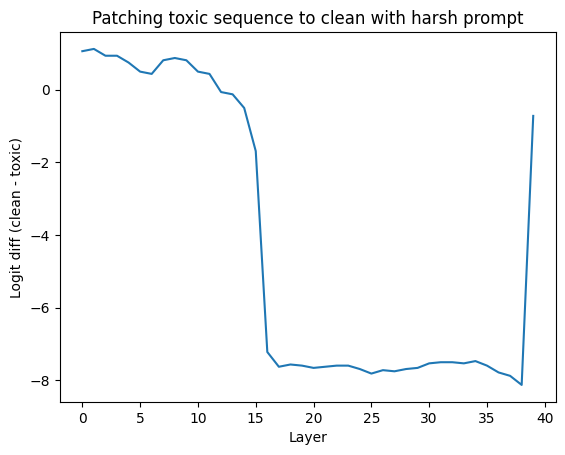

In [45]:
import matplotlib.pyplot as plt

# plt.title("Patching lenient model to be harsh")
plt.title("Patching toxic sequence to clean with harsh prompt")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.plot(results)